**<font size=5>
b站《入海》用户评论数据分析
</font>**

1. 观众性别比例分析
2. 用户客户端分布分析
3. 评论用户等级比例分析
4. 评论时间走势分析
5. 评论内容分析

# 1 数据分析

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import jieba
from collections import Counter

from pyecharts.charts import Bar, Pie, Line, WordCloud, Page
from pyecharts import options as opts
from pyecharts.globals import SymbolType

## 1.1 数据读入

In [2]:
df = pd.read_excel('B站评论数据-入海5.23.xlsx')
df.head()

,用户名,性别,标签,等级,评论,设备,评论时间,点赞数
0,巨星不易工作室,保密,毛不易个人厂牌-巨星不易工作室官方账号,2,祝大家毕业快乐。,phone,1589947664,1928
1,谜一样的剪辑师,男,职业剪辑师，代表作：《啥是佩奇》《巴依尔的春节》,5,该片剪辑路过~这就是我最近在上海剪的MV短片《入海》，终于上线了哈哈，希望大家喜欢。近几天考...,phone,1589938042,395
2,巨星不易工作室,保密,毛不易个人厂牌-巨星不易工作室官方账号,2,快乐的时光总是短暂，我们下次再见。,phone,1589950537,426
3,同济大学,保密,同舟共济,4,毕业快乐，祝大家前程似锦，母校永远在你身后[爱心][爱心],phone,1589942187,245
4,华东师范大学,保密,华东师范大学，魔都985双一流A类高校。人称“爱在华师大”，又名“华东吃饭大学”、“东中国正...,5,祝所有毕业生前程似锦，万事胜意❤,NaN,1589938758,244


In [3]:
df.shape

(19099, 8)

数据共计19099条，包括了八个字段：

- 用户名
- 用户性别
- 用户标签
- 用户账号等级
- 评论内容
- 使用设备
- 评论时间
- 点赞数

## 1.2 数据预处理

### 1.2.1 删除重复值

现有的数据中可能存在一些重复值，会影响后续统计的结果，在预处理阶段需要删除这些重复数据。

In [4]:
df = df.drop_duplicates()

In [5]:
df.shape

(19099, 8)

查看删除重复后的数据量，依然是19099行，说明原数据中没有完全相同的数据出现。

使用info()这个方法查看数据摘要，包括所有列的列表，非空值的数量以及数据类型

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19099 entries, 0 to 19098
Data columns (total 8 columns):
用户名     19099 non-null object
性别      19099 non-null object
标签      9896 non-null object
等级      19099 non-null int64
评论      19099 non-null object
设备      4159 non-null object
评论时间    19099 non-null int64
点赞数     19099 non-null int64
dtypes: int64(3), object(5)
memory usage: 1.3+ MB


结果中的non-null表示对应列有多少条非空数据。dtypes表示数据的类型。

### 1.2.2 更改时间类型

把时间戳转换为我们常用的表示形式：YYYY-MM-DD HH:MM:SS

In [7]:
df['评论时间'] = pd.to_datetime(df['评论时间'], unit='s')
df['评论时间'] = df['评论时间'].dt.tz_localize('utc').dt.tz_convert('Asia/Shanghai').dt.strftime('%Y-%m-%d %H:%M:%S').astype(str)
df.head()

,用户名,性别,标签,等级,评论,设备,评论时间,点赞数
0,巨星不易工作室,保密,毛不易个人厂牌-巨星不易工作室官方账号,2,祝大家毕业快乐。,phone,2020-05-20 12:07:44,1928
1,谜一样的剪辑师,男,职业剪辑师，代表作：《啥是佩奇》《巴依尔的春节》,5,该片剪辑路过~这就是我最近在上海剪的MV短片《入海》，终于上线了哈哈，希望大家喜欢。近几天考...,phone,2020-05-20 09:27:22,395
2,巨星不易工作室,保密,毛不易个人厂牌-巨星不易工作室官方账号,2,快乐的时光总是短暂，我们下次再见。,phone,2020-05-20 12:55:37,426
3,同济大学,保密,同舟共济,4,毕业快乐，祝大家前程似锦，母校永远在你身后[爱心][爱心],phone,2020-05-20 10:36:27,245
4,华东师范大学,保密,华东师范大学，魔都985双一流A类高校。人称“爱在华师大”，又名“华东吃饭大学”、“东中国正...,5,祝所有毕业生前程似锦，万事胜意❤,NaN,2020-05-20 09:39:18,244


## 1.3 数据可视化

### 1.3.1 评论用户性别占比

用户注册时，性别可选“男”、“女”或“保密”。在统计时，忽略选择“保密”的用户，不计入结果。

使用value_counts方法统计“性别”一列的不同数据总和，再使用drop方法把“保密”一栏删除，最后打印得到结果。

In [8]:
sex_num = df['性别'].value_counts()
sex_num.drop('保密', inplace=True)
print(sex_num)

男    4537
女    3759
Name: 性别, dtype: int64


In [9]:
data_pair =  [list(z) for z in zip(sex_num.index.tolist(), sex_num.values.tolist())]

# 绘制饼图
pie1 = Pie(init_opts=opts.InitOpts(width='900px', height='500px'))
pie1.add('', data_pair, radius=['35%', '60%'])
pie1.set_global_opts(title_opts=opts.TitleOpts(pos_left='center', title='评论用户性别占比'),
                     legend_opts=opts.LegendOpts(orient='vertical', pos_top='15%', pos_right='25%'))
pie1.set_series_opts(label_opts=opts.LabelOpts(formatter="{b}:{d}%"))
pie1.set_colors(['#3B7BA9', '#ff0000', '#6FB27C'])
pie1.render('评论用户性别占比.html')

C:\ProgramData\Anaconda3\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)


'C:\\Users\\陈方舟\\Desktop\\Python\\小象学院\\7个课程内项目资料包\\数据分析\\毛不易《入海》评论数据分析\\评论用户性别占比.html'

![](评论用户性别占比.png)

### 1.3.2 客户端分布

In [10]:
device_num = df.设备.value_counts(ascending=True)

# 条形图
bar1 = Bar(init_opts=opts.InitOpts(width='900px', height='500px'))
bar1.add_xaxis(device_num.index.tolist())
bar1.add_yaxis('', device_num.values.tolist(),
               label_opts=opts.LabelOpts(position='right'))
bar1.set_global_opts(title_opts=opts.TitleOpts(pos_left='center', title='评论客户端分布'),
                     yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(font_size=15))
                    )
bar1.set_series_opts(label_opts=opts.LabelOpts(position='right', color='black'))
bar1.reversal_axis()
bar1.render('评论客户端分布条形图.html')

C:\ProgramData\Anaconda3\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)


'C:\\Users\\陈方舟\\Desktop\\Python\\小象学院\\7个课程内项目资料包\\数据分析\\毛不易《入海》评论数据分析\\评论客户端分布条形图.html'

![](评论客户端分布条形图.png)

由上图可知，iPhone的用户占了很大的比例，远超Android系统的用户，平板用户排名第三。

### 1.3.3 评论用户等级占比

In [11]:
level_num = df.等级.value_counts()
level_num

5    6894
4    5026
3    3547
2    3013
6     619
Name: 等级, dtype: int64

In [12]:
data_pair2 =  [list(z) for z in zip(['LV' + i for i in level_num.index.astype('str').tolist()] , level_num.values.tolist())]
# 将6移到最前面
data_pair2.insert(0, data_pair2.pop())

pie2 = Pie(init_opts=opts.InitOpts(width='900px', height='500px'))
pie2.add('', data_pair=data_pair2, radius=['35%', '60%'])
pie2.set_global_opts(title_opts=opts.TitleOpts(pos_left='center', title='评论用户等级分布'),
                     legend_opts=opts.LegendOpts(orient='vertical', pos_top='15%', pos_left='15%'))
pie2.set_series_opts(label_opts=opts.LabelOpts(formatter="{b}:{c}({d}%)"))
pie2.set_colors(['#FF2D2D', '#FF5809', '#CC9933', '#33CCCC', '#33CC33'])
pie2.render('评论用户等级占比.html')

C:\ProgramData\Anaconda3\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)


'C:\\Users\\陈方舟\\Desktop\\Python\\小象学院\\7个课程内项目资料包\\数据分析\\毛不易《入海》评论数据分析\\评论用户等级占比.html'

![](评论用户等级占比.png)

在《入海》这首歌的评论用户上，评论中5级的占比最高为36.1%，接着是4级占比26.31%，6级占比最低仅为3.24%。

### 1.3.4 评论时间走势图

这首歌的MV是5月20日在B站发布的，那么从发布到成功登上热搜，这期间哪个时段用户的评论量最大，引起的话题最多呢？

下面我们一起来看看评论量走势和时间的关系。

统计的数据都产生在2020年，年份这个时间标识可以忽略，只观察日期和小时带来的影响。我们额外添加一条时间的字段，然后再查看一下前几行数据。

In [13]:
df['时间'] = df.评论时间.str.split('-').str[1] + '-' + df.评论时间.str.split('-').str[2]
df.head()

,用户名,性别,标签,等级,评论,设备,评论时间,点赞数,时间
0,巨星不易工作室,保密,毛不易个人厂牌-巨星不易工作室官方账号,2,祝大家毕业快乐。,phone,2020-05-20 12:07:44,1928,05-20 12:07:44
1,谜一样的剪辑师,男,职业剪辑师，代表作：《啥是佩奇》《巴依尔的春节》,5,该片剪辑路过~这就是我最近在上海剪的MV短片《入海》，终于上线了哈哈，希望大家喜欢。近几天考...,phone,2020-05-20 09:27:22,395,05-20 09:27:22
2,巨星不易工作室,保密,毛不易个人厂牌-巨星不易工作室官方账号,2,快乐的时光总是短暂，我们下次再见。,phone,2020-05-20 12:55:37,426,05-20 12:55:37
3,同济大学,保密,同舟共济,4,毕业快乐，祝大家前程似锦，母校永远在你身后[爱心][爱心],phone,2020-05-20 10:36:27,245,05-20 10:36:27
4,华东师范大学,保密,华东师范大学，魔都985双一流A类高校。人称“爱在华师大”，又名“华东吃饭大学”、“东中国正...,5,祝所有毕业生前程似锦，万事胜意❤,NaN,2020-05-20 09:39:18,244,05-20 09:39:18


现在时间是以05-20 12:07:44这样类似的模式存放，我们要统计各小时评论数量，第一个冒号后的分钟和秒数都可以忽略不考虑。

下面用冒号：分割“时间”这栏的数据就能得到我们需要的日期和小时的数据。

In [14]:
df['时间'] = df.时间.str.split(':').str[0]
time_num = df.时间.value_counts().sort_index()
time_num[:5]

05-20 08    1277
05-20 09    1433
05-20 10    1229
05-20 11    1333
05-20 12    2772
Name: 时间, dtype: int64

下面选用面积图来表示时间和评论数量之间的关系，设定横坐标为时间，纵坐标表示评论数量。

In [15]:
x1_line1 = time_num.index.values.astype('str').tolist()
y1_line1 = time_num.values.tolist()

In [16]:
# 绘制面积图
line1 = Line(init_opts=opts.InitOpts(width='900px', height='500px'))
line1.add_xaxis(x1_line1)
line1.add_yaxis('', y1_line1, areastyle_opts=opts.AreaStyleOpts(opacity=0.3),
                markpoint_opts=opts.MarkPointOpts(data=[
                    opts.MarkPointItem(type_='max', name='最大值')
                ]))
line1.set_global_opts(title_opts=opts.TitleOpts(pos_left='center', title='各个时段评论人数'),
                      xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(rotate='30'))
                     )
line1.set_series_opts(label_opts=opts.LabelOpts(is_show=False),
                      axisline_opts=opts.AxisLineOpts()
                     )
line1.render('各个时段评论人数面积图.html')

C:\ProgramData\Anaconda3\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)


'C:\\Users\\陈方舟\\Desktop\\Python\\小象学院\\7个课程内项目资料包\\数据分析\\毛不易《入海》评论数据分析\\各个时段评论人数面积图.html'

![](各个时段评论人数面积图.png)

从5月20日8:30发布MV后，评论数量逐渐上升，12点左右有一个快速增加，达到高峰。后续随着时间的推移，评论人数逐渐减少，趋于平缓。

### 1.3.5 评论词云图

In [17]:
def get_cut_words(content_series):
    # 读入停用词表
    stop_words = []

    with open(r"stop_words.txt", 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            stop_words.append(line.strip())
    
    for i in range(len(df['评论'])):
        if type(df['评论'].loc[i]) != str:
            temp = str(df['评论'].loc[i])
            df['评论'].loc[i] = temp
     
    word_num = jieba.lcut(content_series.str.cat(sep='。'), cut_all=False)

    # 条件筛选
    word_num_selected = [i for i in word_num if i not in stop_words and len(i) >= 2]

    return word_num_selected

In [18]:
text = get_cut_words(content_series=df['评论'])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\陈方舟\AppData\Local\Temp\jieba.cache
Loading model cost 1.071 seconds.
Prefix dict has been built successfully.


C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\site-packages\wordcloud\wordcloud.py:35: ResourceWarning: unclosed file <_io.TextIOWrapper name='C:\\ProgramData\\Anaconda3\\lib\\site-packages\\wordcloud\\stopwords' mode='r' encoding='cp936'>
  STOPWORDS = set(map(str.strip, open(os.path.join(FILE, 'stopwords')).readlines()))


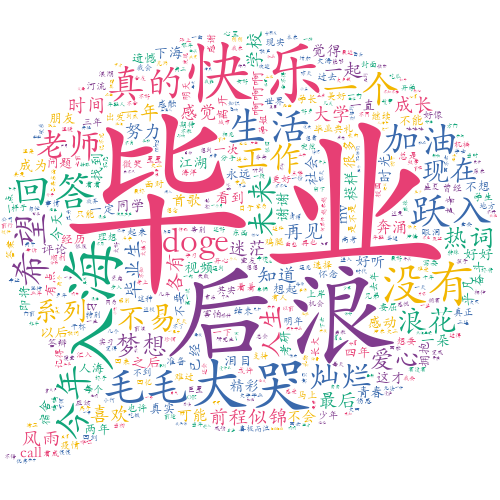

In [19]:
import stylecloud
from IPython.display import Image  # 用于在jupyter lab中显示本地图片

# 绘制词云图
stylecloud.gen_stylecloud(text=' '.join(text),
                          collocations=False,
                          font_path='STKAITI.TTF',
                          icon_name='fas fa-comment',
                          size=500,
                          output_name='评论词云图.png')
Image(filename='评论词云图.png')

可以看到，评论中出现最多的词有“毕业”、“后浪”、“大哭”、“快乐”、“生活”、“老师”、“加油”、“希望”等。